In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.scouring.scouring import aggregate_time_series

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [5]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
end_date = datetime.datetime(2023,4,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
home_folder = "../../"
data_path = home_folder + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"

turbine_data = pd.read_parquet(data_path).loc[:end_date]
turbine_data = turbine_data.loc[~turbine_data.index.duplicated(keep='first')]
weather_station_data_LAT = pd.read_parquet(weather_data_path).loc[:end_date]


# Get all the data
data = pd.read_parquet(data_path).loc[:end_date]
mvbc_data = pd.read_parquet(weather_data_path).loc[:end_date]
tracked_frequencies = pd.read_parquet(tracked_frequencies_path).loc[:end_date]
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)


name_location = 'NW2_D01'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

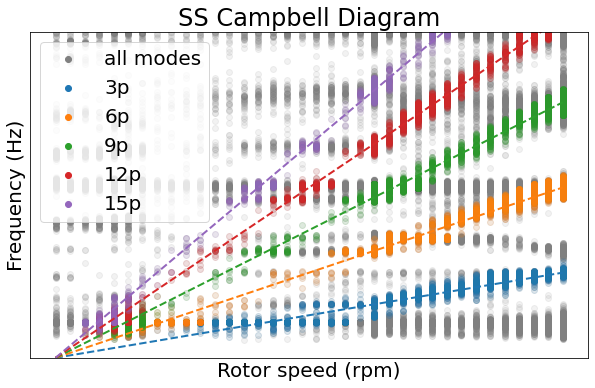

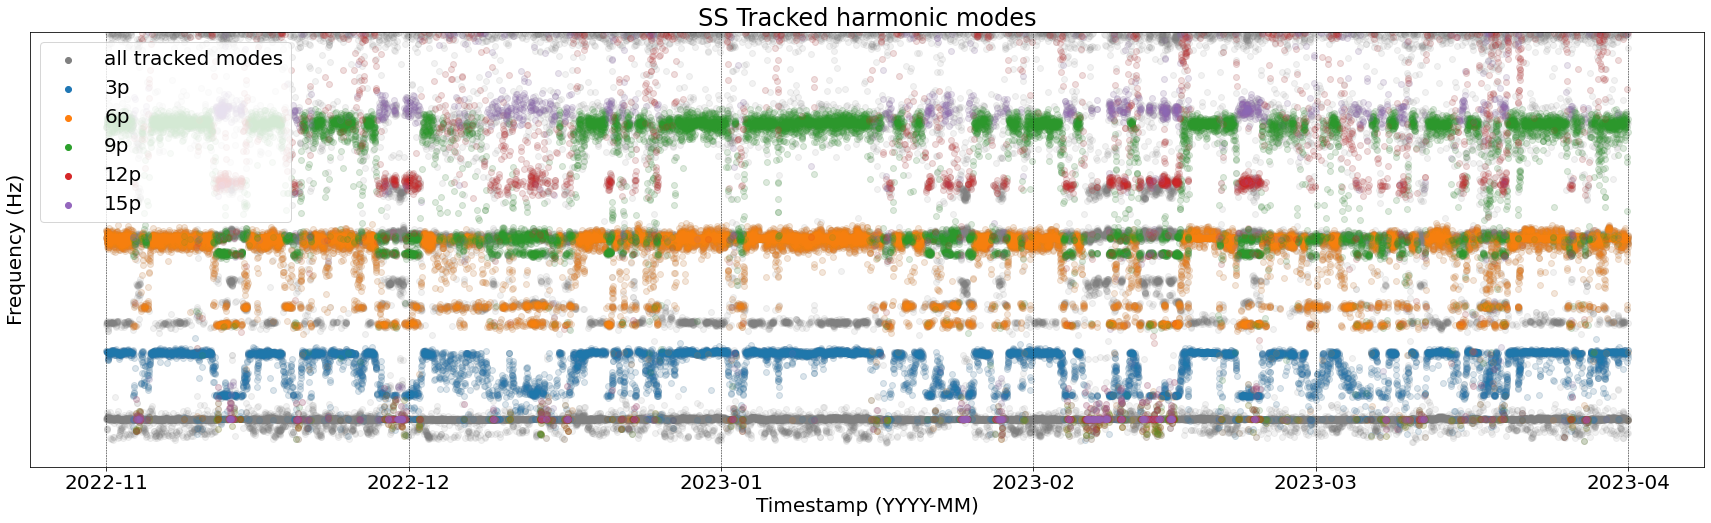

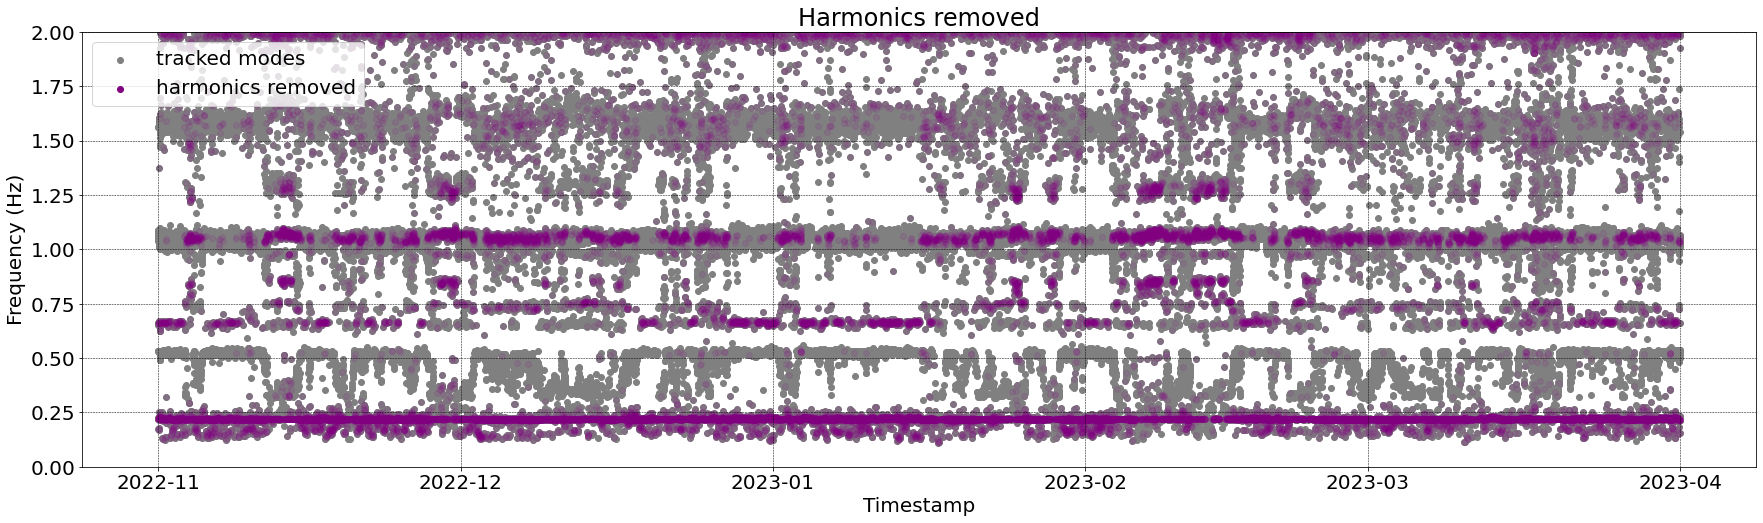

In [6]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
plt.rcParams.update({'font.size': 20})
clustering_data = {}
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS']:
    clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], min_rpm=0, max_distance = 0.08, p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


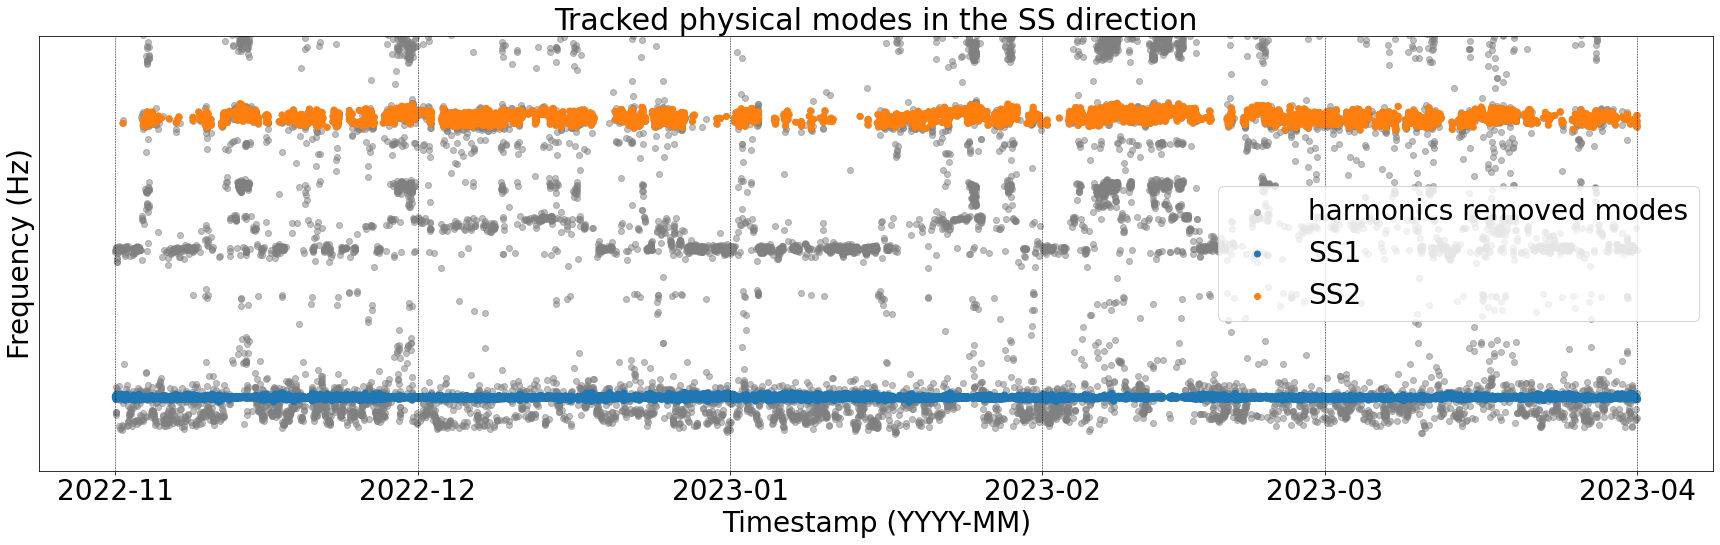

In [7]:
direction = 'SS'
mc = {}
clustered_modes = {}
plt.rcParams.update({'font.size': 28})  # Set the font size to 12


mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=2000)

plt.figure(figsize=(30,8))

plt.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab10')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = plt.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.scatter([], [], c='#FF800E')
plt.legend(['harmonics removed modes', 'SS1', 'SS2'])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Timestamp (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked physical modes in the SS direction', fontsize=30)
plt.ylim(0, 1.3)
plt.yticks([])

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

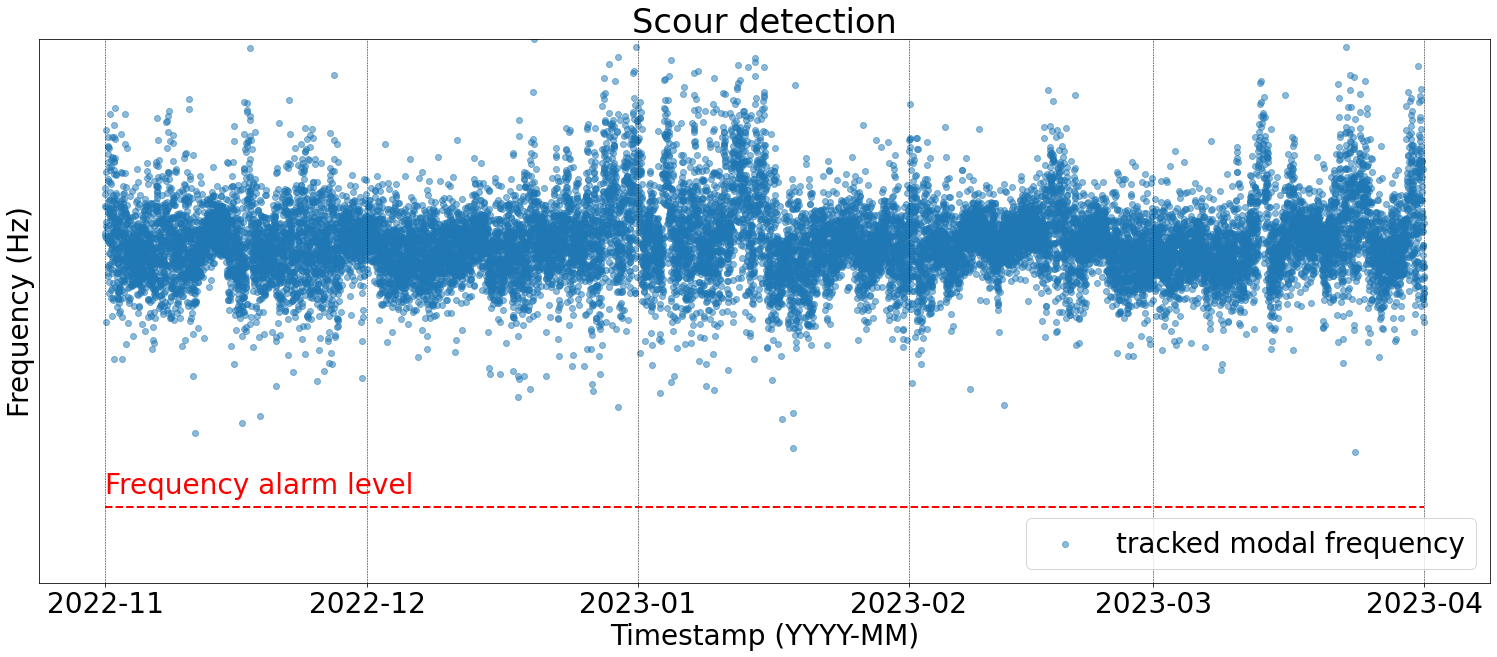

In [8]:
import numpy as np 
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

end_training = datetime.datetime(2023, 3, 1)
end_test = datetime.datetime(2023, 4, 1)
mode = 'SS1'

# Create a grid of subplots
sigma = tracked_frequencies[mode].std()
mean = tracked_frequencies[mode].mean()
plt.figure(figsize=(26,10))
plt.scatter(tracked_frequencies[mode].index, tracked_frequencies[mode], label = 'tracked modal frequency', alpha = 0.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Timestamp (YYYY-MM)')
plt.title('Scour detection')
plt.yticks([])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.ylim(mean-9*sigma, tracked_frequencies[mode].max())

# plot 3 sigma lines
plt.hlines(mean-7*sigma, tracked_frequencies[mode].index[0], tracked_frequencies[mode].index[-1], color='r', linestyle='--', linewidth=2)
plt.text(tracked_frequencies[mode].index[0], mean-7*sigma+ 0.001, 'Frequency alarm level', color='r')
plt.legend(loc='lower right')
plt.show()

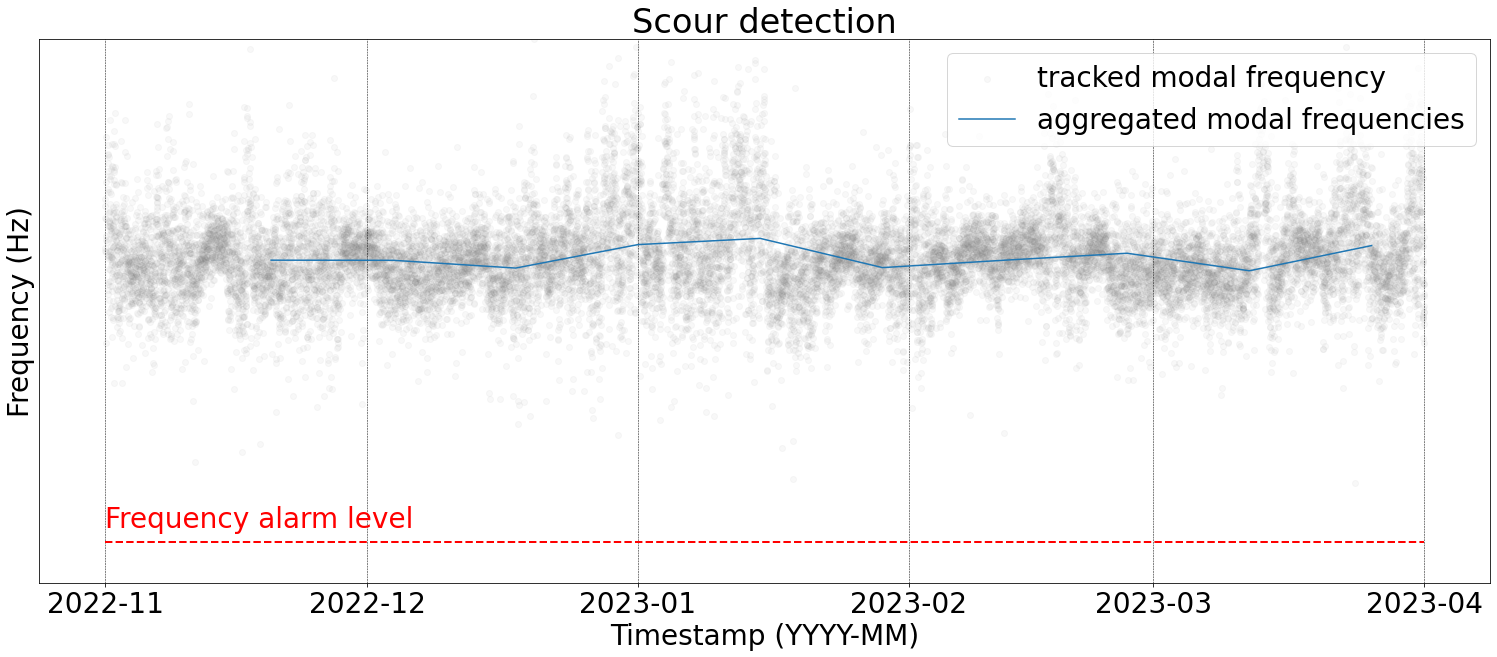

In [13]:

import numpy as np 
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

end_training = datetime.datetime(2023, 3, 1)
end_test = datetime.datetime(2023, 4, 1)
mode = 'SS1'


aggretagted_data = aggregate_time_series(tracked_frequencies[mode],'2W')

# Create a grid of subplots
sigma = tracked_frequencies[mode].std()
mean = tracked_frequencies[mode].mean()
plt.figure(figsize=(26,10))
plt.scatter(tracked_frequencies[mode].index, tracked_frequencies[mode], label = 'tracked modal frequency', alpha = 0.05, color='grey')
plt.plot(aggretagted_data, label = 'aggregated modal frequencies')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Timestamp (YYYY-MM)')
plt.title('Scour detection')
plt.yticks([])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.ylim(mean-8*sigma, tracked_frequencies[mode].max())

# plot 3 sigma lines
plt.hlines(mean-7*sigma, tracked_frequencies[mode].index[0], tracked_frequencies[mode].index[-1], color='r', linestyle='--', linewidth=2)
plt.text(tracked_frequencies[mode].index[0], mean-7*sigma+ 0.001, 'Frequency alarm level', color='r')
plt.legend(loc='upper right')
plt.show()